# Map statistics of objects in one channel in relation to overlapping objects in another channel

In [1]:
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from colormaps import glasbey_cmap
from napari_skimage_regionprops import regionprops_map_channels_table

# Create a multichannel intensity image and a 'multichannel' label image

The channel dimention is the first.

In [2]:
seed = 42
np.random.seed(seed)
multichannel_image = np.random.randint(0, 20, size = 72, ).reshape(2, 6, 6)

Our reference labels are in axis 0.

In [3]:
ref_labels = np.zeros((6,6), dtype=int)
ref_labels[2:5, 2:5] = 1

probe_labels = np.zeros((6,6), dtype=int)
probe_labels[3:5, 2:4] = 2
probe_labels[4, 1] = 2
probe_labels[4, 4] = 1
probe_labels[1, 1] = 3

multichannel_labels = np.stack([ref_labels, probe_labels], axis=0)

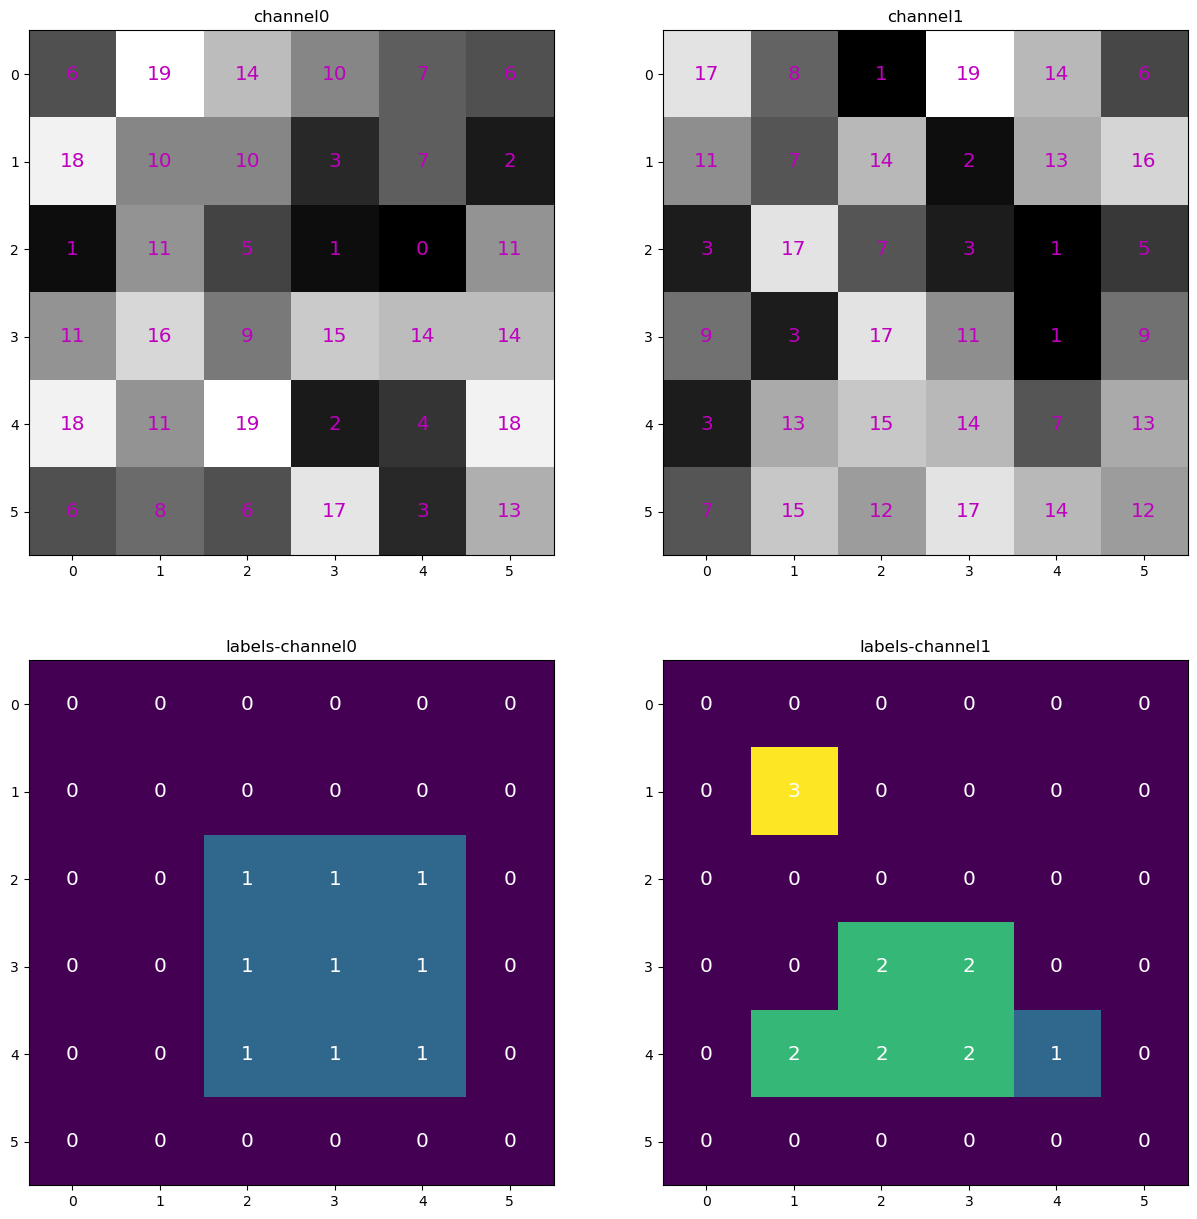

In [15]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
for i in range(multichannel_image.shape[0]):
    ax[0,i].set_title('channel' + str(i))
    ax[0,i].imshow(multichannel_image[i], cmap='gray')
    for k in range(multichannel_image.shape[1]):
        for j in range(multichannel_image.shape[2]):
            ax[0,i].text(j, k, multichannel_image[i, k, j], ha="center", va="center", color="m", fontsize='x-large')
    ax[1,i].set_title('labels-channel' + str(i))
    ax[1,i].imshow(multichannel_labels[i], interpolation='none', vmax=3)
    for k in range(multichannel_labels.shape[1]):
        for j in range(multichannel_labels.shape[2]):
            ax[1,i].text(j, k, multichannel_labels[i, k, j], ha="center", va="center", color="w", fontsize='x-large')

# Define properties to measure, degree of overlap and whether to display summary statistics or not

Check a list of available properties on [scikit-image.regionprops](https://scikit-image.org/docs/stable/api/skimage.measure.html#regionprops) or add your own property by providing a custom function in a scikit-image acceptable format.

In [5]:
properties = ['area', 'mean_intensity']

intersection_area_over_object_area = 0.5 # 1 for full overlap (objects must be completly inside), 0 for no overlap (all objects are in background)

ref_channel = 0

summary = True

In [6]:
table_list = regionprops_map_channels_table(multichannel_labels, 
                                          multichannel_image,
                                          size = True,
                                          intensity = False,
                                          ref_channel = ref_channel,
                                          intersection_area_over_object_area = intersection_area_over_object_area, 
                                          summary = summary)

In [7]:
table_list[0]

label-ch0 area-ch1                                         bbox_area-ch1  \
               count mean       std  min  25%  50%  75%  max         count   
0         0      1.0  1.0       NaN  1.0  1.0  1.0  1.0  1.0           1.0   
1         1      2.0  3.0  2.828427  1.0  2.0  3.0  4.0  5.0           2.0   

   ... convex_area-ch1      equivalent_diameter-ch1                     \
   ...             75%  max                   count      mean      std   
0  ...             1.0  1.0                     1.0  1.128379      NaN   
1  ...             4.0  5.0                     2.0  1.825756  0.98624   

                                                     
        min       25%       50%       75%       max  
0  1.128379  1.128379  1.128379  1.128379  1.128379  
1  1.128379  1.477068  1.825756  2.174444  2.523133  

[2 rows x 33 columns]

# Count number of objects 'inside' objects in another channel

The 'count' column of any metric gives this information. Here, we use 'area-ch1' as an example.

In [8]:
counts = pd.DataFrame(table_list[0][('area-ch1', 'count')])
counts

,area-ch1
,count
0,1.0
1,2.0


This means '1.0' object from ch1 is in the background (index/object #0) of ch0.

And '2.0' objects of ch1 are inside of (overlap with) object #1 of ch0.

# Get mean area of objects 'inside' objects in another channel

In [9]:
area_mean = pd.DataFrame( table_list[0] [ ('area-ch1', 'mean') ] )
area_mean

,area-ch1
,mean
0,1.0
1,3.0


This implies that objects with mean area of '1.0' from ch1 are in the background (index/object #0) of ch0.

And it implies that objects with mean area of '2.0' from ch1 are inside of (overlap with) object #1 of ch0.

# Get full table with individual relationships

If you like, you can access the full table by setting 'summary' to False.

In [10]:
summary = False

In [13]:
table_list = regionprops_map_channels_table(multichannel_labels, 
                                          multichannel_image, 
                                          size = True,
                                          intensity = False,
                                          ref_channel = ref_channel,
                                          intersection_area_over_object_area = intersection_area_over_object_area, 
                                          summary = summary,
                                         )

In [14]:
table_list[0]

,label-ch0,area-ch0,bbox_area-ch0,convex_area-ch0,equivalent_diameter-ch0,label-ch1,area-ch1,bbox_area-ch1,convex_area-ch1,equivalent_diameter-ch1
0,0,NaN,NaN,NaN,NaN,3,1,1,1,1.128379
1,1,9.0,9.0,9.0,3.385138,1,1,1,1,1.128379
2,1,9.0,9.0,9.0,3.385138,2,5,6,5,2.523133


This implies that:
  - 'label-ch1' #3 (yellow pixel) belongs to 'label-ch0' #0 (background);
  - 'label-ch1' #1 (blue pixel) belongs to 'label-ch0' #1 (big blue square);
  - 'label-ch1' #2 (green object) also belongs to 'label-ch0' #1 (big blue square);
  
Depending on the `intersection_area_over_object_area` value, the green object could or could not belong to the big blue square.

For example, if we increase `intersection_area_over_object_area` to 1, then the green object must be fully 'inside' to be considered as belonging to the big blue square. Therefore, it is assigned to the background, as shown below.

In [16]:
table_list = regionprops_map_channels_table(multichannel_labels, 
                                          multichannel_image, 
                                          size = True,
                                          intensity = False,
                                          ref_channel = ref_channel,
                                          intersection_area_over_object_area = 1, 
                                          summary = summary,
                                         )

In [17]:
table_list[0]

,label-ch0,area-ch0,bbox_area-ch0,convex_area-ch0,equivalent_diameter-ch0,label-ch1,area-ch1,bbox_area-ch1,convex_area-ch1,equivalent_diameter-ch1
0,0,NaN,NaN,NaN,NaN,2,5,6,5,2.523133
1,0,NaN,NaN,NaN,NaN,3,1,1,1,1.128379
2,1,9.0,9.0,9.0,3.385138,1,1,1,1,1.128379
